### Importing the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import datetime
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf 
import warnings
warnings.simplefilter("ignore")
from sklearn.metrics import mean_squared_error
from math import sqrt
from dateutil.relativedelta import relativedelta
from datetime import date, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ipywidgets as widgets

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install chart_studio
import chart_studio
import chart_studio.plotly as py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.4 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=74688490977fdd1697ee6e82e9e5f24a01ebb6794e368a99e88baeb0575f3ec7
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


### Loading the Data Set

In [3]:
data = pd.read_csv("Inflation.csv")
data

,observation_date,Monthly_CPI,Monthly_Inflation,Monthly_Rate,Bank Rate
0,1960-01-01,1.678984,1.000000,0.000000,4.00
1,1960-02-01,1.678984,1.000000,0.000000,4.00
2,1960-03-01,1.664416,0.991323,-0.867679,4.00
3,1960-04-01,1.678984,1.008753,0.875274,4.00
4,1960-05-01,1.689910,1.006508,0.650759,4.00
...,...,...,...,...,...
716,2019-09-01,123.175008,1.006250,0.625000,5.65
717,2019-10-01,124.322601,1.009317,0.931677,5.65
718,2019-11-01,125.470194,1.009231,0.923077,5.65
719,2019-12-01,126.235257,1.006098,0.609756,5.65


###   Seasonal Trend

In [ ]:
widget = widgets.IntRangeSlider(value=[1975, 2000], min=1960, max=2020, step=1, description='Time Period:', 
        disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
widget

##### Plotting monthly inflation over the selected time period to check if the time series has any seasonality

In [5]:
#Prepare Data
years = widget.value
years = list(range(years[0],years[1]+1))

data['Year'] = pd.DatetimeIndex(data['observation_date']).year
data['Month'] = pd.DatetimeIndex(data['observation_date']).month

#Draw Plot
fig = go.Figure()

for i,y in enumerate(years):
    if i<len(years):
        fig.add_trace(go.Scatter(
            x=data[data['Year']==years[i]].Month.tolist(),
            y=data[data['Year']==years[i]].Monthly_Rate.round(2).tolist(),
            name=str(years[i])))
#Layout changes
fig.update_layout(title=go.layout.Title(
        text="Seasonal Trend of Monthly Inflation Rate",
        xref="paper",
        x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Month",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))
fig.update_yaxes(nticks=10)
   
fig.show()

In [6]:
# py.plot(fig, filename = 'SARIMAX Forecasting', auto_open=True)

**From the graph above it is evident that inflation rate is high in April, then peaks again in June and July, dips in August, peaks in October and finally dips in December. This shows that there exists an evident seasonal trend in our time series data. This important observation leads us to believe that we will be required to use SARIMAX instead of the simple ARIMAX Model**

### EXPLORATORY ANALYSIS

### Splitting the data into two time periods: Train and Valid 

In [7]:
Train = data[data.Year < 1996]
Valid = data[data.Year > 1995]

**We need to train our model on data from the past first using the 'Train' dataset and then we forecast monthly inflation which we validate with the actual data in the 'Valid' dataset.**

**Train data:** 1960-1996 

**Valid data:** 1996-2020

**Our training set will be around 60% and valid set will be around 40% of the entire data set.**

### Visualize the data

In [8]:
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=Train.observation_date, y=Train.Monthly_Rate, mode='lines+markers', name= 'Train')))
fig.add_trace(go.Scatter(dict(x=Valid.observation_date, y=Valid.Monthly_Rate, mode='lines+markers', name= 'Valid')))

fig.update_layout(title=go.layout.Title(
        text="Monthly Infaltion Rates for 1960-2020",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()

**Blue line denotes the Train data and red line denotes the Valid data**

**A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Property of constant variance is known as homoskedasticity. If a time series is stationary and has a particular behaviour over a given time interval, then it is safe to assume that it will have same behaviour at some later point in time. Therefore, a stationarized series is easier to predict.
The Train data is not stationary as the inflation rates are not uniformly distributed around 0. However, this is a very informal method to check for stationarity.**

In [9]:
# py.plot(fig, filename = 'Monthly Infaltion Rates for 1960-2020', auto_open=True)

### Seasonal Decomposition of Data

**Time series data is composed of Level, Trend, Seasonality and Random noise. Let’s decompose the data and plot the trend, seasonality and randomness in the data.**

**We use statsmodel for seasonal decompose and the frequency of the time series which is the periodicity of the data is 12 months for an yearly data.**

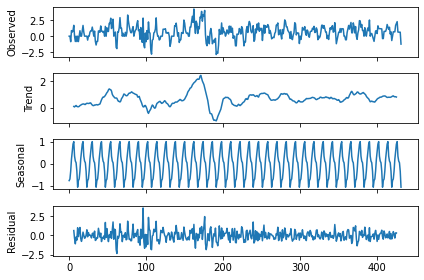

In [11]:
result = seasonal_decompose(Train['Monthly_Rate'].dropna(), model='additive', freq =12)
result.plot()
plt.show()

**From this graph we can see if the data has any sort of trend in any component. We can see the graphs labelled 'Observed', 'Trend', and 'Residual' are fluctuating randomly, i.e they exhibit no observable trend. The seasonal graph, however, shows that there exists an evident seasonal trend that we’re required to remove before proceeding to modelling.**

### Formal checks for Stationarity

**There are two primary ways to determine whether a given time series is stationary:**

* **Plotting data along with Rolling Average and Rolling Standard Deviation:** The time series is stationary if it remains steady with time.

* **Augmented Dickey-Fuller Test:** The time series is considered stationary if the p-value is low (<0.05) and the Test Statistic is lower than the critical values at 1%, 5%, 10% levels of significance.

**A 12-month rolling mean would average out the inflation rates for the first 12 months as the first data point shown at the 12th point. The next data point would drop the first inflation rate and add the rate at the 13th month and take the average of inflation rates from months 2-13, and so on.**

##### Defining the check for Data Stationarity using Rolling Mean and Rolling Standard Deviation

In [12]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    fig= go.Figure()
    fig.add_trace(go.Scatter(dict(x=data.observation_date, y=ts, mode='lines+markers', name= 'Original Data')))
    fig.add_trace(go.Scatter(dict(x=data.observation_date, y=rol_mean, mode='lines', name= 'Rolling Mean',line=dict(color='black', width=2))))
    fig.add_trace(go.Scatter(dict(x=data.observation_date, y=rol_std, mode='lines', name= 'Rolling Standard',line=dict(color='brown', width=2))))

    fig.update_layout(title=go.layout.Title(
        text="Rolling Mean & Standard Deviation",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

    fig.show()

##### Defining the check for Data Stationarity using Augmented Dickey Fuller(ADF) test

In [13]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

**We use the AD Fuller test to check stationarity with Bayesian Information Criterion (BIC). BIC is based on the likelihood function and is closely related to the Akaike information criterion (AIC). It is possible to increase the likelihood of the model by using unnecessary parameters which results in over fitting. The BIC resolves this imposing a greater penalty for the number of parameters in the model than the AIC.**

##### Plotting the original data set and testing it using the ADF test

In [14]:
TestStationaryPlot(data["Monthly_Rate"])
adf_test(data["Monthly_Rate"].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -4.675526
p-value                          0.000094
#Lags Used                      11.000000
Number of Observations Used    709.000000
Critical Value (1%)             -3.439607
Critical Value (5%)             -2.865625
Critical Value (10%)            -2.568945
dtype: float64


**It is evident from the graph that the data set is not stationary as the rolling mean and standard deviation are fluctuating a lot about 0.**

**The ADF test suggests that the data set is stationary as the p-value is extremely small and the Test Statistic is lower than the critical values at 1%, 5%, 10% levels of significance.**

**Therefore, we need to look at both these tests simultaneously as independently they may give biased results.**

**Thus, we can conclude that the original time series data is not stationary.**


##### Plotting the Train data set and testing it using the ADF test

In [15]:
TestStationaryPlot(Train["Monthly_Rate"].dropna(inplace=False))
adf_test(Train["Monthly_Rate"].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.128842e+01
p-value                        1.399250e-20
#Lags Used                     0.000000e+00
Number of Observations Used    4.310000e+02
Critical Value (1%)           -3.445614e+00
Critical Value (5%)           -2.868269e+00
Critical Value (10%)          -2.570354e+00
dtype: float64


**Again, it is evident from the graph that the data set is not stationary as the rolling mean and standard deviation are fluctuating greatly.**

**The ADF test suggests that the data set is stationary as the p-value is extremely small and the Test Statistic is lower than the critical values at 99%, 95%, 90% confidence intervals.**

**Thus, we can conclude that the Train time series is not stationary and will require differencing to make it stationary.**

### <b> DIFFERENCING - ELIMINATING TREND AND SEASONALITY

### <b> First Difference

In [16]:
Train_first_difference = Train["Monthly_Rate"] - Train["Monthly_Rate"].shift(1)  

##### Plotting the first difference of the Train data set and testing it using the ADF test

In [17]:
TestStationaryPlot(Train_first_difference.dropna(inplace=False))
adf_test(Train_first_difference.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.456443e+01
p-value                        4.737113e-27
#Lags Used                     8.000000e+00
Number of Observations Used    4.220000e+02
Critical Value (1%)           -3.445941e+00
Critical Value (5%)           -2.868413e+00
Critical Value (10%)          -2.570431e+00
dtype: float64


**From the graph we can observe that though the rolling mean is remarkably steady, the rolling standard deviation has not smoothened by much.**

**From the ADF test, the p-value is extremely small and the Test Statistic is lower than the critical values at each confidence interval lesser than or equal to 99%.**

**This implies that the first difference Train data is stationary. While this helped to improve the stationarity of the data, it is not there yet. Our next step is to take a seasonal difference to remove the seasonality of the data and see how that impacts the stationarity of the data.**

### <b> Seasonal Difference

**In Train_seasonal_difference we subtract current values from values 12 months back to get rid of seasonality.
For example, inflation in May, 1998 is subtracted by inflation is May, 1997.**

In [18]:
Train_seasonal_difference = Train["Monthly_Rate"] - Train["Monthly_Rate"].shift(12)  
Train_seasonal_difference.tail()

427   -0.43
428   -0.78
429    0.28
430   -0.06
431   -0.56
Name: Monthly_Rate, dtype: float64

##### Plotting the seasonal difference of the Train data set and testing it using the ADF test

In [19]:
TestStationaryPlot(Train_seasonal_difference.dropna(inplace=False))
adf_test(Train_seasonal_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -9.462848e+00
p-value                        4.307353e-16
#Lags Used                     1.100000e+01
Number of Observations Used    4.080000e+02
Critical Value (1%)           -3.446480e+00
Critical Value (5%)           -2.868650e+00
Critical Value (10%)          -2.570557e+00
dtype: float64


**The graph shows that the rolling mean and standard deviation are fluctuating greatly and hence, the data set is not stationary even though the ADF test suggests otherwise.**

**As first difference improves the stationarity of series, we will take the first difference of seasonal difference.**

### Seasonal First Difference

In [20]:
Train_seasonal_first_difference = Train_seasonal_difference - Train_seasonal_difference.shift(1)  

##### Plotting the seasonal first difference of the Train data set and testing it using the ADF test

In [21]:
TestStationaryPlot(Train_seasonal_first_difference.dropna(inplace=False))
adf_test(Train_seasonal_first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -5.904346e+00
p-value                        2.730904e-07
#Lags Used                     1.100000e+01
Number of Observations Used    4.070000e+02
Critical Value (1%)           -3.446520e+00
Critical Value (5%)           -2.868668e+00
Critical Value (10%)          -2.570567e+00
dtype: float64


**From the graph we can observe that the rolling mean has now stabilized greatly and the rolling standard deviation has also smoothened out a bit indicating that this data set is stationary.**

**The ADF test suggests that the p-value is extremely small and the Test Statistic is less than all the critical values mentioned in the test. This supplements our observation from the graph and we can thus conclude that the seasonal first difference Train data is stationary.** 

### Checking degree of seasonality over various data sets

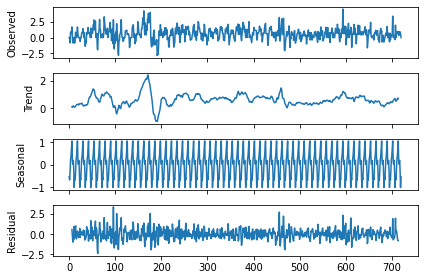

In [22]:
#Seasonal Decomposition of original data
result = seasonal_decompose(data['Monthly_Rate'].dropna(), model='additive', freq =12)
result.plot()
plt.show()

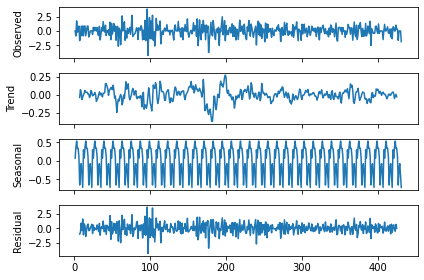

In [23]:
#Seasonal Decomposition of first difference of Train data
result = seasonal_decompose(Train_first_difference.dropna(), model='additive', freq =12)
result.plot()
plt.show()

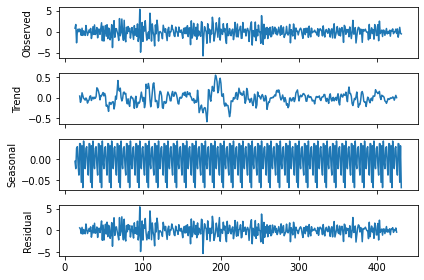

In [24]:
#Seasonal Decomposition of seasonal first difference of Train data
result = seasonal_decompose(Train_seasonal_first_difference.dropna(), model='additive', freq =12)
result.plot()
plt.show()

### BUILDING THE MODEL

### <b> Selecting Parameters using Autocorrelation and Partial Autocorrelation graphs

**The parameters of the ARIMA model are defined as follows:**

* **p: The number of lag observations included in the model, also called the Autoregressive terms**
* **d: The number of times that the raw observations are differenced, also called the degree of differencing**
* **q: The size of the moving average window, also called the Moving Average terms**

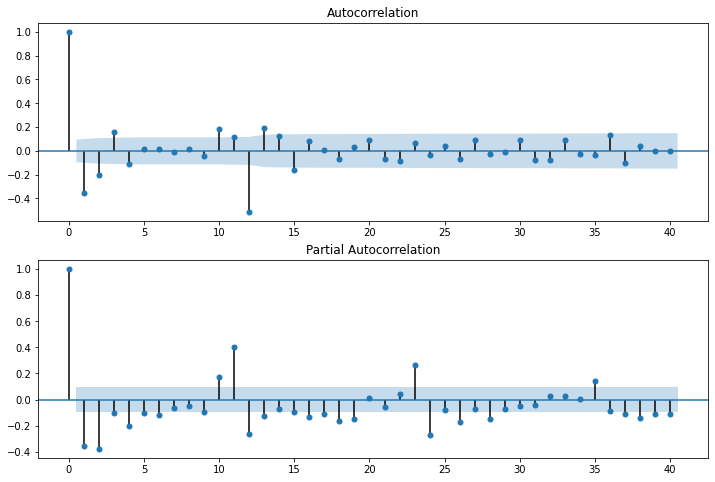

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

#Autocorrelation Graph for 40 periods
fig = sm.graphics.tsa.plot_acf(Train_seasonal_first_difference.dropna(), lags=40, ax=ax1)

#Partial autocorrelation Graph for 40 periods
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Train_seasonal_first_difference.dropna(), lags=40, ax=ax2)

**The shaded region in both the graphs represents a 95% confidence interval band. Anything outside the shaded region signifies a statistically significant correlation.**

* **The autocorrelation graph displays the correlation between the observations at the current point in time and the observations at all previous points in time. Spike in autocorrelation graphs tells us the number of Auto-Regressive (AR) terms or the number of lags.**
* **The partial autocorrelation graph displays the duration of the influence of a random shock, i.e. correlation which is not explained by the set of explanatory variables. Spike in the partial autocorrelation tells us the number of Moving Average (MR) Terms.**<br><br>

**In the autocorrelation graph we observe significant spikes at 0, 1, 2 and 3 but in order to avoid the risk of over-fitting our model we don't consider 3.**
**In the partial autocorrelation graph we observe a significant spikes at 0, 1, 2 only.**<br><br>

                                   Auto-Regressive terms = Lags = p = [0,1,2]

                                        Moving Average terms = q = [0,1,2]
                                               

### <b>SARIMAX Model

In [26]:
sar = pd.DataFrame(Train["Bank Rate"])
# Introducing a lag of 5 quarters 
sar["Bank Rate Lagged"] = sar["Bank Rate"].shift(15)
#Solving for NAN values
sar["Bank Rate Lagged"].fillna(0, inplace = True)

In [27]:
y_hat_avg = Valid.copy() 
fit1= SARIMAX(Train["Monthly_Rate"], order=(1, 0, 1),seasonal_order=(1,1,0,12), exog = sar["Bank Rate Lagged"], 
             trend='ct', simple_differencing=False,enforce_stationarity=False).fit()
print(fit1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       Monthly_Rate   No. Observations:                  432
Model:             SARIMAX(1, 0, 1)x(1, 1, 0, 12)   Log Likelihood                -561.866
Date:                            Mon, 25 Jul 2022   AIC                           1137.732
Time:                                    04:46:43   BIC                           1165.794
Sample:                                         0   HQIC                          1148.838
                                            - 432                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.0544      0.049      1.103      0.270      -0.042       0.151
drift            

### Predicting forecasts 

In [28]:
length = Train.shape[0]-1
x = data.loc[length:,"Bank Rate"]
x = x.shift(15)
x.fillna(0, inplace = True)
pred = pd.DataFrame(x)
pred.shape

(290, 1)

**Once fit, the model can be used to make a forecast.**

**A forecast can be made by calling the forecast() or the predict() functions on the fitted SARIMAXResults.**

In [29]:
y_hat_avg['SARIMAX'] = fit1.predict(start=431, end=721, dynamic=True, exog = pred) 

In [30]:
fig= go.Figure()

fig.add_trace(go.Scatter(dict(x=Train.observation_date, y=Train['Monthly_Rate'], mode='lines', name= 'Train')))
fig.add_trace(go.Scatter(dict(x=Valid.observation_date, y=Valid['Monthly_Rate'], mode='lines', name= 'Valid',line=dict(width=2))))
fig.add_trace(go.Scatter(dict(x=Valid.observation_date, y=y_hat_avg['SARIMAX'], mode='lines', name= 'SARIMA',line=dict(width=2))))

fig.update_layout(title=go.layout.Title(
        text="SARIMAX Prediction",
        xref="paper",x=0),
        margin=dict(l=10, r=0, t=50, b=50),
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()

In [32]:
Valid.Monthly_Rate=np.where(np.isnan(Valid.Monthly_Rate), 0, Valid.Monthly_Rate)
y_hat_avg.SARIMAX=np.where(np.isnan(y_hat_avg.SARIMAX), 0, y_hat_avg.SARIMAX)
rms = sqrt(mean_squared_error(Valid.Monthly_Rate, y_hat_avg.SARIMAX.dropna())) 
print("\033[1m The root mean squared error of the predicted inflation by SARIMAX and inflation in the Valid data set is "+ str(round(rms,4)))

 The root mean squared error of the predicted inflation by SARIMAX and inflation in the Valid data set is 1.7256


In [33]:
std=Valid.Monthly_Rate.std()
print("\033[1m The standard deviation of the inflation in the Valid data set is " + str(round(std,4)))
error= round(round(rms,4) - round(std,4),4)
print("\033[1m The error in our model's prediction is " + str(error)+"%")

 The standard deviation of the inflation in the Valid data set is 0.8347
 The error in our model's prediction is 0.8909%


##### Plotting the residual density and estimating its distribution 

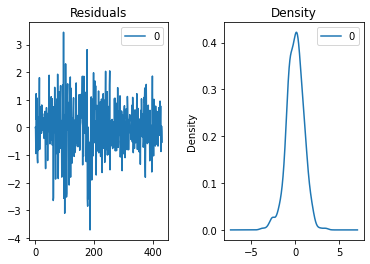

                0
count  432.000000
mean    -0.002362
std      0.952980
min     -3.707869
25%     -0.596089
50%      0.031298
75%      0.613285
max      3.447520


In [34]:
residuals = pd.DataFrame(fit1.resid)
fig, ax = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.3, wspace=0.4)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
print(residuals.describe())

**The mean of residuals is 0.006 which is exceptionally close to 0 and the graph resembles a normally distributed series, thus complementing our belief that the model is accurate.**<br><br>

**We now need to forecast monthly inflation rates for India for the years 2020-2040. In order to do so we would first need to predict the future 'Bank Rate' that is used as an exogenous variable in our model.**

### <b> Predicting Bank Rate using ARIMA for the period 2020 - 2040

In [35]:
date_list = []
start = datetime.datetime(2020,2,1)
for x in range(0,251): 
    dates = (start + relativedelta(months=x)).strftime("%Y-%m-%d")
    date_list.append(dates)
col = pd.Series(date_list)
df = pd.DataFrame()
df['observation_date'] = col
data = pd.concat((data,df))
data.reset_index(inplace=True)
data['Bank Rate'].fillna(0,inplace= True)

**We have added future observation_dates in our DataFrame using pd.concat. Now we will predict future Bank Rates for these newly added time periods and plot them.**

**We can create and fit an ARIMA model with AR of order 1, differencing of order 0 and MA of order 0.**<br>
**We choose the order = (1,0,0) for the ARIMA model.**

In [36]:
fit2= ARIMA(data["Bank Rate"], order=(1, 0, 0)).fit(disp=0)
print(fit2.summary())

                              ARMA Model Results                              
Dep. Variable:              Bank Rate   No. Observations:                  972
Model:                     ARMA(1, 0)   Log Likelihood                -130.896
Method:                       css-mle   S.D. of innovations              0.276
Date:                Mon, 25 Jul 2022   AIC                            267.792
Time:                        04:46:45   BIC                            282.430
Sample:                             0   HQIC                           273.363
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.0758      2.765      1.474      0.141      -1.344       9.496
ar.L1.Bank Rate     0.9976      0.002    547.040      0.000       0.994       1.001
                                

In [37]:
pred_uc = fit2.predict(start = 721, dynamic=True)
results = pd.Series(pred_uc)
df = pd.DataFrame()
df['Bank Rate'] = results
data.loc[721:, 'Bank Rate'] = df
data

,index,observation_date,Monthly_CPI,Monthly_Inflation,Monthly_Rate,Bank Rate,Year,Month
0,0,1960-01-01,1.678984,1.000000,0.000000,4.000000,1960.0,1.0
1,1,1960-02-01,1.678984,1.000000,0.000000,4.000000,1960.0,2.0
2,2,1960-03-01,1.664416,0.991323,-0.867679,4.000000,1960.0,3.0
3,3,1960-04-01,1.678984,1.008753,0.875274,4.000000,1960.0,4.0
4,4,1960-05-01,1.689910,1.006508,0.650759,4.000000,1960.0,5.0
...,...,...,...,...,...,...,...,...
967,246,2040-08-01,NaN,NaN,NaN,4.799632,NaN,NaN
968,247,2040-09-01,NaN,NaN,NaN,4.797864,NaN,NaN
969,248,2040-10-01,NaN,NaN,NaN,4.796101,NaN,NaN
970,249,2040-11-01,NaN,NaN,NaN,4.794341,NaN,NaN


**Concatenating the predicted results of Bank Rates in our original DataFrame.**

### <b> Predicting Monthly Inflation using SARIMAX Model for the period 2020 - 2040

**We choose the order = (1,0,1) and the seasonal order = (1,1,0,12) for the SARIMAX model.**

In [38]:
fit3= SARIMAX(data["Monthly_Rate"], order=(1,0,1), seasonal_order=(1,1,0,12), trend='ct',
              exog = data["Bank Rate"].shift(16).fillna(0),simple_differencing=False,enforce_stationarity=False).fit()

**Predicting the future Indian monthly inflation rate using the predicted Bank Rate. Concatenating the predicted results in our original DataFrame and plotting them.**

In [39]:
forecast = fit3.predict(start=722, dynamic= True, exog= df) 
inflation = pd.Series(forecast)
inf_rate = pd.DataFrame()
inf_rate['Monthly_Rate'] = inflation
data.loc[721:, 'Monthly_Rate'] = inf_rate['Monthly_Rate']
data

,index,observation_date,Monthly_CPI,Monthly_Inflation,Monthly_Rate,Bank Rate,Year,Month
0,0,1960-01-01,1.678984,1.000000,0.000000,4.000000,1960.0,1.0
1,1,1960-02-01,1.678984,1.000000,0.000000,4.000000,1960.0,2.0
2,2,1960-03-01,1.664416,0.991323,-0.867679,4.000000,1960.0,3.0
3,3,1960-04-01,1.678984,1.008753,0.875274,4.000000,1960.0,4.0
4,4,1960-05-01,1.689910,1.006508,0.650759,4.000000,1960.0,5.0
...,...,...,...,...,...,...,...,...
967,246,2040-08-01,NaN,NaN,-0.004475,4.799632,NaN,NaN
968,247,2040-09-01,NaN,NaN,0.209640,4.797864,NaN,NaN
969,248,2040-10-01,NaN,NaN,0.519307,4.796101,NaN,NaN
970,249,2040-11-01,NaN,NaN,0.409047,4.794341,NaN,NaN


In [40]:
fig= go.Figure()

fig.add_trace(go.Scatter(dict(x=Valid.observation_date, y=Valid.Monthly_Rate, mode='lines+markers', name='Valid')))
fig.add_trace(go.Scatter(dict(x=Valid.observation_date, y=y_hat_avg['SARIMAX'], mode='lines+markers', name='SARIMAX')))
fig.add_trace(go.Scatter(dict(x=data.loc[721:, "observation_date"], y=forecast, mode='lines+markers', name="Forecast")))

fig.update_layout(title=go.layout.Title(
        text="Forecasted Monthly Inflation",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()